In [104]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from itertools import pairwise
from PIL import Image
from dataclasses import dataclass
%matplotlib inline

In [197]:
@dataclass
class PlotImage:
    image: np.ndarray
    description: str = ''
        
    @property
    def title(self):
        return f'{self.description + " | " if self.description else ""}{self.image.shape}\n[{self.image.min()}, {self.image.max()}] {self.image.dtype}'

    @property
    def cmap(self):
        return None if len(self.image.shape) == 3 else 'gray'
    
        
def plot(*plot_image):
    if len(plot_image) == 1:
        img = plot_image[0]
        plt.imshow(img.image, cmap = img.cmap)
        plt.title(img.title)
    else:
        _, axes = plt.subplots(1, len(plot_image), figsize=(10, 5))
        for (ax, img) in zip(axes, plot_image):
            ax.imshow(img.image, cmap = img.cmap)
            ax.set_title(img.title)
        
    plt.tight_layout()
    plt.show()

In [186]:
def scale_to_uint8(img):
    imin = img.min()
    imax = img.max()

    a = (255 - 0) / (imax - imin)
    b = 255 - a * imax
    return (a * img + b).astype('uint8')

def normalize_to_uint8(img):
    return cv2.normalize(src=img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

def to_gray_scale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

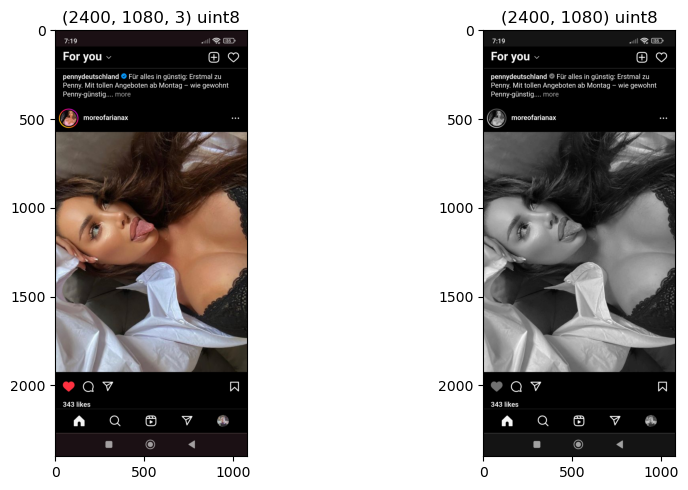

In [184]:
PATH = '../cropbundle/src/androidTest/assets/defective/ariana.jpg'

img = mpimg.imread(PATH)
img_gray = np.asarray(Image.open(PATH).convert('L'))

plot(PlotImage(img), PlotImage(img_gray))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


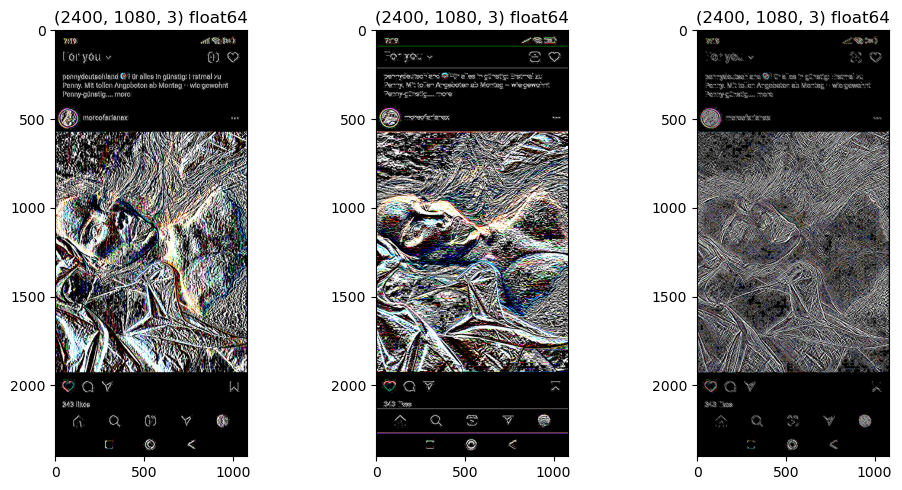

In [162]:
def sobel(image, dx, dy):
    return cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=dx, dy=dy)
    
sobel_1x = sobel(img, dx=1, dy=0)
sobel_1y = sobel(img, dx=0, dy=1)
sobel_1x_1y = sobel(img, dx=1, dy=1)

plot(PlotImage(sobel_1x), PlotImage(sobel_1y), PlotImage(sobel_1x_1y))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


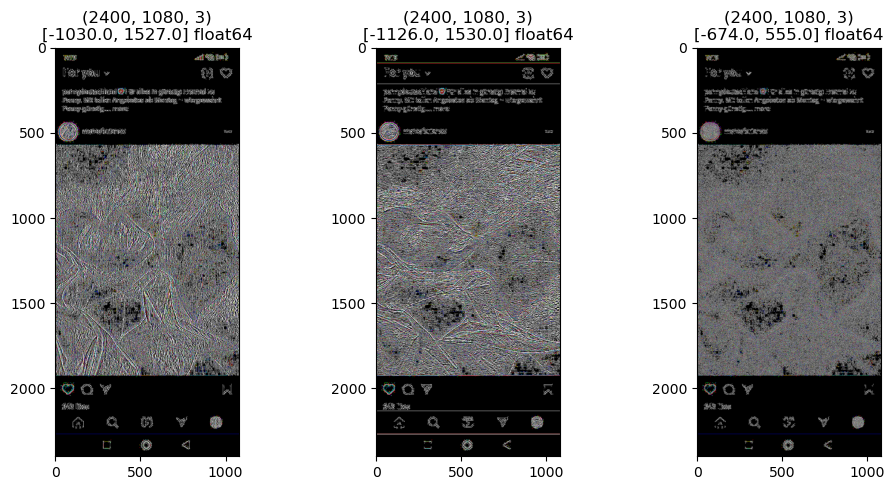

In [198]:
sobel_2x = sobel(img, dx=2, dy=0)
sobel_2y = sobel(img, dx=0, dy=2)
sobel_2x_2y = sobel(img, dx=2, dy=2)

plot(PlotImage(sobel_2x), PlotImage(sobel_2y), PlotImage(sobel_2x_2y))

In [124]:
# lines = cv2.HoughLines(sobel_1y, rho = 1, theta = 1*np.pi/180, threshold = 100, minLineLength = 100, maxLineGap = 50)
cv2.HoughLines??

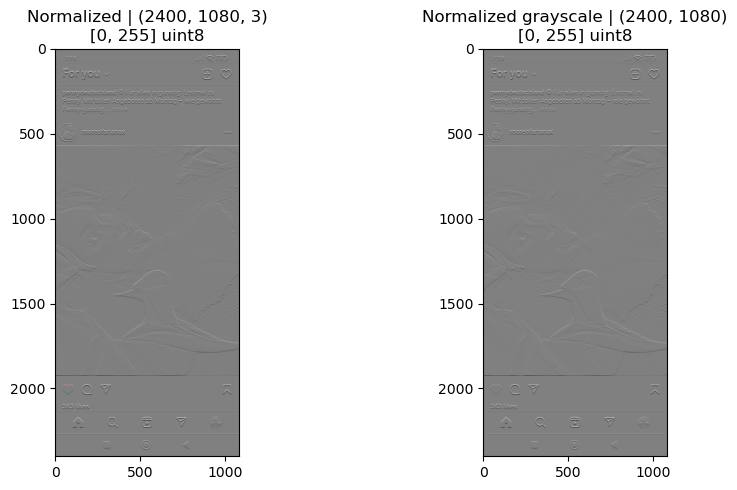

In [199]:
sobel_1y_normalized = normalize_to_uint8(sobel_1y)
sobel_1y_normalized_gray = to_gray_scale(sobel_1y_normalized)

plot(PlotImage(sobel_1y_normalized, 'Normalized'), PlotImage(sobel_1y_normalized_gray, 'Normalized grayscale'))

array([  0, 255], dtype=uint8)

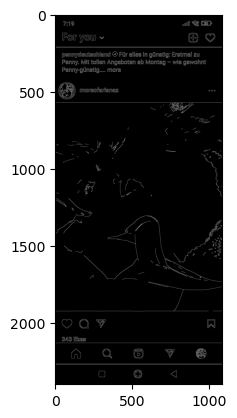

In [11]:
canny_gray = cv2.Canny(img_gray, 100, 200)
plt.imshow(canny_gray, cmap='gray')
np.unique(canny_gray.flatten())

(array([1.915e+03, 3.040e+02, 6.800e+01, 3.400e+01, 1.600e+01, 5.000e+00,
        3.000e+00, 1.200e+01, 1.400e+01, 6.000e+00, 5.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 5.000e+00]),
 array([  0.        ,   4.55357143,   9.10714286,  13.66071429,
         18.21428571,  22.76785714,  27.32142857,  31.875     ,
         36.42857143,  40.98214286,  45.53571429,  50.08928571,
         54.64285714,  59.19642857,  63.75      ,  68.30357143,
         72.85714286,  77.41071429,  81.964285

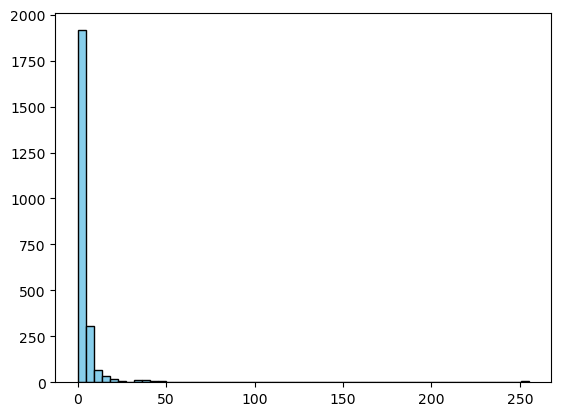

In [29]:
from collections import Counter

non_zero_row_means = filter(lambda x: x != 0, [np.mean(row, dtype = 'int32') for row in canny_gray])
plt.hist(row_means, bins=len(set(non_zero_row_means)), color='skyblue', edgecolor='black')

In [68]:
def _edge_candidates(img_binary, n_candidates = 20):
    non_zero_row_index_and_mean_pairs = []
    for i, row in enumerate(img_binary):
        mean = np.mean(row)
        if mean > 0:
            non_zero_row_index_and_mean_pairs.append((i, mean))
    
    return sorted(non_zero_row_index_and_mean_pairs, key = lambda x: x[1], reverse = True)[:n_candidates]

candidates = edge_candidates(canny_gray)
candidates

[(213, 255.0),
 (216, 255.0),
 (2133, 255.0),
 (2269, 255.0),
 (2272, 255.0),
 (574, 215.09722222222223),
 (1926, 183.45833333333334),
 (275, 102.70833333333333),
 (255, 89.95833333333333),
 (304, 87.83333333333333),
 (324, 87.36111111111111),
 (307, 70.83333333333333),
 (1927, 64.69444444444444),
 (321, 60.68055555555556),
 (314, 53.833333333333336),
 (259, 53.59722222222222),
 (271, 52.888888888888886),
 (312, 51.94444444444444),
 (308, 50.763888888888886),
 (258, 50.05555555555556)]

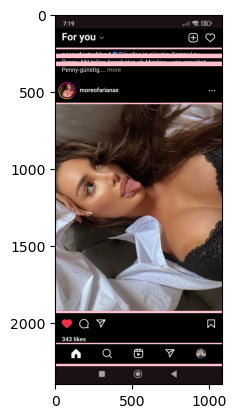

In [41]:
for c in candidates:
    plt.plot([0, img_gray.shape[1]], [c[0], c[0]], color='pink', linewidth=1)
plt.imshow(img)

edges: (324, 574): -20.74 | 0.10 | 0.59
edges: (574, 1926): 7.83 | 0.56 | 0.78
(574, 1926)


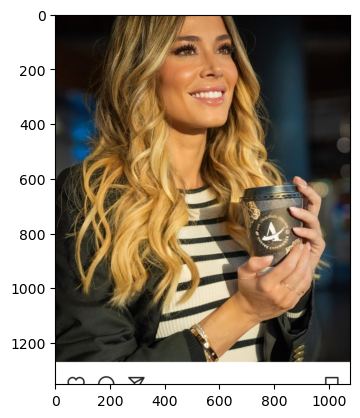

In [71]:
def crop_area(img, edges):
    return img[edges[0]:edges[1], 0:img.shape[1]]

def crop_height(edges):
    return edges[1] - edges[0]

def _crop_edges(candidates, img_sobel):
    height = img_sobel.shape[0]
    
    area_min_height = height * 0.1
    
    # add start and end row to candidates 
    candidates = [(0, 0)] + sorted(candidates, key = lambda x: x[0]) + [(height, 0)]
        
    max_score = -1
    max_score_edge_pair = None
    
    for (i_top, edge_mean_top), (i_bottom, edge_mean_bottom) in pairwise(candidates):
        if i_bottom - i_top > area_min_height:
            edges = (i_top, i_bottom)
            area = crop_area(img_sobel, edges)
            fluctuation = np.mean(area)
            height_proportion = crop_height(edges) / height
            edge_score = (edge_mean_bottom + edge_mean_top) / 510.0
            score = fluctuation + height_proportion + edge_score

            print(f'edges: ({i_top}, {i_bottom}): {fluctuation:.2f} | {height_proportion:.2f} | {edge_score:.2f}')

            if score > max_score:
                max_score = score
                max_score_edge_pair = (i_top, i_bottom)
            
    return max_score_edge_pair

edges = _crop_edges(candidates, sobel_1d)
area = crop_area(img, edges)

print(edges)
plt.imshow(area)

In [84]:
def crop_edges_candidates(img_path):
    gray_scale = np.asarray(Image.open(img_path).convert('L'))
    gray_scale_canny = cv2.Canny(gray_scale, 100, 200)
    plt.imshow(gray_scale_canny, cmap='gray')
    plt.show()
    return _edge_candidates(gray_scale_canny, 10)

def crop_edges_from_candidates(img_path, candidates):
    sobel = cv2.Sobel(src=np.asarray(Image.open(img_path)), ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
    sobel_clipped = np.clip(sobel, 0, 1)
    return _crop_edges(candidates, sobel_clipped)

def crop_edges(img_path):
    candidates = crop_edges_candidates(img_path)
    print(candidates)
    return crop_edges_from_candidates(img_path, candidates)

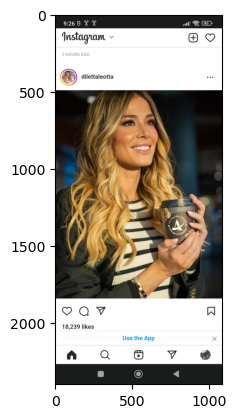

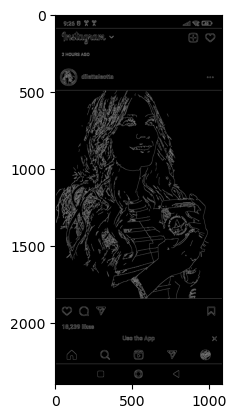

[(92, 255.0), (494, 255.0), (2269, 255.0), (1845, 253.81944444444446), (1203, 36.361111111111114), (1222, 32.583333333333336), (419, 32.34722222222222), (1226, 32.34722222222222), (71, 31.166666666666668), (1227, 30.458333333333332)]
edges: (92, 419): 0.05 | 0.14 | 0.56
edges: (494, 1203): 0.47 | 0.30 | 0.57
edges: (1227, 1845): 0.49 | 0.26 | 0.56
edges: (1845, 2269): 0.07 | 0.18 | 1.00


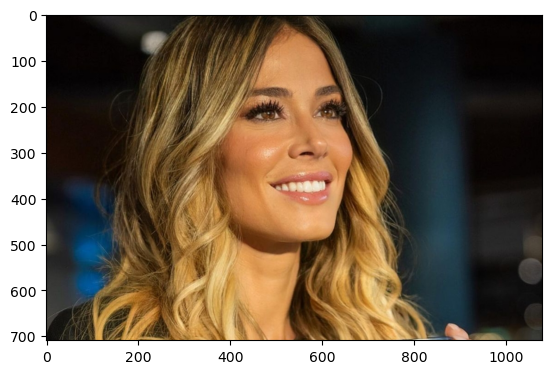

In [85]:
path = '../cropbundle/src/androidTest/assets/defective/Screenshot_2022-12-06-09-26-12-769_com.android.chrome.jpg'
img = np.asarray(Image.open(path))

plt.imshow(img)
plt.show()

edges = crop_edges(path)
plt.imshow(crop_area(img, edges))